In [1]:
#!pip install neuralforecast

In [2]:
import pandas as pd

In [3]:
data = pd.read_excel("C:/Users/Usuario/Documents/Projectes/ChallengeAuditoria/challenge-auditoria/data/inventory_data_month.xlsx")


ts = ['Jan_2022', "Feb_2022", "Mar_2022", "Apr_2022", "May_2022", "Jun_2022", "Jul_2022", "Aug_2022", "Sep_2022", "Oct_2022", "Nov_2022", "Dec_2022", 'Jan_2023', "Feb_2023", "Mar_2023", "Apr_2023", "May_2023", "Jun_2023", "Jul_2023", "Aug_2023", "Sep_2023", "Oct_2023", "Nov_2023", "Dec_2023"]
data.fillna(0, inplace=True)
print(data.columns)
ts.extend(["material", "vendes_2022", "vendes_2023"])
data = data[ts]

Index(['Unnamed: 0.1', 'Unnamed: 0', 'material', 'unitats_2022', 'vendes_2022',
       'preu_venda_unitari_2022', 'unitats_2023', 'vendes_2023',
       'preu_venda_unitari_2023', 'variacio_preu_venda_unitari_2022_2023',
       'proporcio_variacio_preu_venda_unitari_2022_2023',
       'data_darrera_entrada', 'dies_ultima_entrada', 'data_darrera_sortida',
       'dies_ultima_sortida', 'diferencia_entrada_sortida', 'stock_final_2023',
       'valor_total_stock_2023', 'cost_unitari_stock_2023', 'Jan_2022',
       'Jan_2023', 'Feb_2022', 'Feb_2023', 'Mar_2022', 'Mar_2023', 'Apr_2022',
       'Apr_2023', 'May_2022', 'May_2023', 'Jun_2022', 'Jun_2023', 'Jul_2022',
       'Jul_2023', 'Aug_2022', 'Aug_2023', 'Sep_2022', 'Sep_2023', 'Oct_2022',
       'Oct_2023', 'Nov_2022', 'Nov_2023', 'Dec_2022', 'Dec_2023'],
      dtype='object')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10416\649198885.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.fillna(0, inplace=True)


In [4]:
df = pd.DataFrame(data)

# Unpivot the DataFrame
df = df.melt(id_vars=["material", "vendes_2022", "vendes_2023"], var_name='ds', value_name='y')

# Extract year and month from 'ds' column
df['ds'] = pd.to_datetime(df['ds'], format='%b_%Y')

# Rename the 'material' column to 'unique_id'
df.rename(columns={'material': 'unique_id'}, inplace=True)

print(df)

      unique_id  vendes_2022  vendes_2023         ds             y
0     114230822     54892.49     58951.87 2022-01-01   1002.876978
1     115030252      6825.62      2127.68 2022-01-01     56.596995
2     115070602    100307.84     34522.45 2022-01-01   6079.577671
3     115130209      5179.48      3770.68 2022-01-01    259.045453
4     115170581     26188.50     74195.50 2022-01-01   1180.711925
...         ...          ...          ...        ...           ...
9187  182080257     27030.19     17886.40 2023-12-01   1257.852506
9188  182080258      3945.01         0.00 2023-12-01      0.000000
9189  182080259    112860.80    326272.67 2023-12-01  26980.031073
9190  182080260      8513.28     11016.96 2023-12-01      0.000000
9191  182130161    457202.60    390388.11 2023-12-01  43500.579629

[9192 rows x 5 columns]


In [5]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS, TimesNet, FEDformer

nf = NeuralForecast(
    models = [NBEATS(input_size=13, h=12, max_steps=100, hist_exog_list = ["vendes_2022", "vendes_2023"]),
              TimesNet(input_size=13, h=12, max_steps=100),
              FEDformer(input_size=13, h=12, max_steps=100)
              ],
    freq = 'M'
)

nf.fit(df=df)
new_df = nf.predict()

c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
600       Non-trainable params
2.4 M     Total params
9.690     Total estimated model params size (MB)


c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n

Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s] 

c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s, v_num=22, train_loss_step=9.89e+3, train_loss_epoch=8.06e+3]         

c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 31. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 8:  33%|███▎      | 4/12 [00:00<00:01,  6.33it/s, v_num=22, train_loss_step=7.64e+3, train_loss_epoch=7.05e+3] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 8:  33%|███▎      | 4/12 [00:00<00:01,  6.30it/s, v_num=22, train_loss_step=7.64e+3, train_loss_epoch=7.05e+3]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 4.7 M 
4 | enc_embedding  | DataEmbedding | 192   
5 | layer_norm     | LayerNorm     | 128   
6 | predict_linear | Linear        | 312   
7 | projection     | Linear        | 65    
-------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.752    Total estimated model params size (MB)


Epoch 8:  33%|███▎      | 4/12 [00:05<00:11,  0.71it/s, v_num=23, train_loss_step=18.10, train_loss_epoch=230.0]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 8:  33%|███▎      | 4/12 [00:05<00:11,  0.71it/s, v_num=23, train_loss_step=18.10, train_loss_epoch=230.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 384   
5 | dec_embedding | DataEmbedding | 384   
6 | encoder       | Encoder       | 161 K 
7 | decoder       | Decoder       | 177 K 
------------------------------------------------
339 K     Trainable params
0         Non-trainable params
339 K     Total params
1.359     Total estimated model params size (MB)



Epoch 8:  33%|███▎      | 4/12 [00:07<00:14,  0.55it/s, v_num=24, train_loss_step=7.45e+3, train_loss_epoch=5.99e+3] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 8:  33%|███▎      | 4/12 [00:07<00:14,  0.55it/s, v_num=24, train_loss_step=7.45e+3, train_loss_epoch=5.99e+3]

c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\utilsforecast\processing.py:362: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\utilsforecast\processing.py:414: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 59.84it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 14.93it/s]


c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [6]:
new_df.head()

,ds,NBEATS,TimesNet,FEDformer
unique_id,,,,
114230822,2023-12-31,5754.993164,5683.444824,4468.245117
114230822,2024-01-31,5427.899414,6718.735352,4453.424805
114230822,2024-02-29,4789.617188,6198.358398,4438.791016
114230822,2024-03-31,6387.427246,8089.680176,4424.273438
114230822,2024-04-30,5989.224121,5609.387207,4409.607422


In [7]:
def save_result(new_df, name):
    df = pd.DataFrame(new_df)

    # Convert 'ds' column to datetime
    df['ds'] = pd.to_datetime(df['ds'])

    # Pivot the DataFrame
    df_pivot = df.pivot_table(index='unique_id', columns='ds', values=f'{name}', aggfunc='first')

    # Reset index to make 'unique_id' a column again
    df_pivot.reset_index(inplace=True)

    # Rename columns
    df_pivot.columns.name = None  # Remove the name of the columns index
    df_pivot.columns = ['unique_id'] + [col.strftime('%b_%Y') for col in df_pivot.columns[1:]]

    print(df_pivot)

    df_pivot = df_pivot.drop(["Dec_2023"], axis=1)
    forecasts = df_pivot.set_index('unique_id').T.to_dict(orient='list')
    import json
    new_forecasts = {key: list(value) for key, value in forecasts.items()}
    # Saving the dictionary to a JSON file
    with open(f"../forecast/{name}.json", "w") as json_file:
        json.dump(new_forecasts, json_file)

    return df_pivot

times_net_df =save_result(new_df, 'TimesNet')
save_result(new_df, 'NBEATS')
save_result(new_df, 'FEDformer')

     unique_id      Dec_2023      Jan_2024      Feb_2024      Mar_2024  \
0    114230822   5683.444824   6718.735352   6198.358398   8089.680176   
1    115030252     29.447693     82.648346     19.445480     28.154022   
2    115070602     14.385742    190.172852    204.369141   -733.944336   
3    115130209     55.557281     96.026947     57.048645     23.273682   
4    115170581   6594.920898   8530.551758   6857.986328   8251.452148   
..         ...           ...           ...           ...           ...   
378  182080257   1633.328857   1715.333374   1789.099365   1589.961304   
379  182080258    -11.405964     -7.583454      0.028225    -30.679569   
380  182080259  27359.343750  28440.375000  26196.181641  29659.181641   
381  182080260    393.740479    442.560211    379.795410    -61.202576   
382  182130161  40730.632812  43166.953125  45495.390625  49292.257812   

         Apr_2024      May_2024      Jun_2024      Jul_2024      Aug_2024  \
0     5609.387207   5998.307617   

,unique_id,Jan_2024,Feb_2024,Mar_2024,Apr_2024,May_2024,Jun_2024,Jul_2024,Aug_2024,Sep_2024,Oct_2024,Nov_2024
0,114230822,4453.424805,4438.791016,4424.273438,4409.607422,4395.074219,4380.575195,4265.670410,4098.623047,3942.016602,4133.061035,5023.529297
1,115030252,79.407059,81.009140,82.958023,84.708534,86.705040,88.728065,94.075943,96.837379,112.649940,134.839798,203.356339
2,115070602,1653.364380,1679.096436,1705.109375,1731.079102,1757.286011,1783.459473,1836.155396,1800.025757,2005.094238,2267.914307,3031.065186
3,115130209,195.747986,196.305603,196.479523,196.549698,196.509842,196.448471,191.768829,193.718506,210.556046,236.931992,240.855469
4,115170581,5089.468750,5130.737793,5172.241699,5213.597656,5255.177246,5296.777832,5344.599609,5324.601562,5569.124023,5906.108398,6993.424316
...,...,...,...,...,...,...,...,...,...,...,...,...
378,182080257,1530.626587,1512.581665,1494.816406,1476.275269,1457.467651,1438.863037,1397.652588,1399.746216,1332.052734,1273.271484,1260.859497
379,182080258,24.678049,25.110846,25.547707,25.920238,26.298330,26.617107,28.629988,31.805056,36.086254,39.315083,30.825027
380,182080259,24099.410156,24294.833984,24490.359375,24685.906250,24881.544922,25077.210938,25016.673828,23747.759766,24292.140625,23841.796875,30725.017578
381,182080260,432.588257,430.902405,429.293610,427.619324,426.037567,424.710999,378.868164,324.337067,337.230164,423.006226,772.604980


In [23]:
datan = data.drop(["vendes_2022", "vendes_2023"], axis=1)
merged_df = pd.merge(datan, times_net_df, left_on='material', right_on='unique_id')  # Use 'unique_id' if that's the common column

import matplotlib.pyplot as plt
# Set the index to 'material_id' or 'unique_id' depending on which one you merged on
# You can also set it to another relevant column if needed
merged_df.set_index('material', inplace=True)  # Use 'unique_id' if that's the common column
merged_df.columns


merged_df= merged_df.drop("unique_id", axis=1)



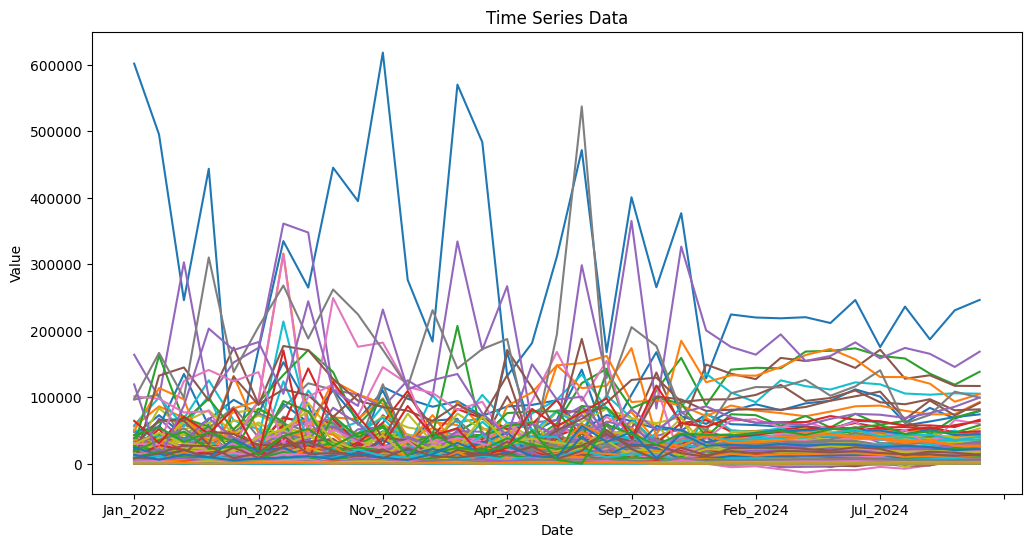

In [25]:
# Plot the time series
merged_df.transpose().plot(kind='line', figsize=(12, 6), legend=False)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Model preentrenat

No furula

In [8]:
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS

nf2 = NBEATS.load_from_checkpoint(checkpoint_path='./nbeats_m4.ckpt',h=12,input_size=12)
Y_hat_df = nf2.predict().reset_index()
Y_hat_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/Usuario/Documents/Projectes/ChallengeAuditoria/challenge-auditoria/monthly_ts/nbeats_m4.ckpt'